In [12]:
import pandas as pd
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, make_scorer, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
import pickle
import glob

In [3]:
def apply_vif(df_test, var_names, verbose=False):
    
    for var in var_names:

        if var in df_test.columns:

            y = df_test[var]
            X = df_test[df_test.columns].drop(columns=[var])
            
            r_squared = np.linalg.lstsq(X, y, rcond=None)[0]
            vif = 1.0 / (1.0 - r_squared)
            
            cols_drop = list(pd.DataFrame(vif, columns=['vif']).sort_values(by='vif', ascending=False).query("vif >= 5").reset_index()['index'])
            
            if len(cols_drop) >  0:
                cols_drop_df = list(X.columns[cols_drop])
                if verbose:
                    print(f"{var}, Columnas a eliminar: {cols_drop_df}")
                df_test = df_test.drop(cols_drop_df, axis=1)
            
    return df_test

# FRAUD PROBLEM

In [4]:
df_identity = pd.read_csv('train_identity.csv')
df_transaction = pd.read_csv('train_transaction.csv')

In [5]:
df_full = pd.merge(df_transaction, df_identity, on='TransactionID', how='left')
df_full.shape

(590540, 434)

In [96]:
df_full

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.50,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.00,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.00,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.00,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.00,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.00,W,6550,NaN,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,3577536,0,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590537,3577537,0,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590538,3577538,0,15811088,117.00,W,7826,481.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
df_full.dtypes

TransactionID       int64
isFraud             int64
TransactionDT       int64
TransactionAmt    float64
ProductCD          object
                   ...   
id_36              object
id_37              object
id_38              object
DeviceType         object
DeviceInfo         object
Length: 434, dtype: object

TransactionDT: Intervalo de tiempo a partir de una fecha y hora de referencia.

TransactionAMT: Importe del pago de la transacción en USD.

ProductCD: Código de producto, el producto de cada transacción.

card1 - card6 : Información de la tarjeta de pago, como tipo de tarjeta, categoría de tarjeta, banco emisor, país, etc.

addr : Dirección

dist: Distancia

P_ and (R_) emaildomain: Dominio de correo electrónico del comprador y del destinatario.

C1-C14 : Recuento, cuántas direcciones se encuentran asociadas a la tarjeta de pago, etc. El significado real está codificado.

D1-D15 : Intervalo de tiempo, como los días transcurridos entre la transacción anterior, etc.

M1-M9 : Coinciden, como los nombres en la tarjeta y la dirección, etc.

Vxxx : Vesta ofrece una gran variedad de funciones, como la clasificación, el recuento y otras relaciones entre entidades.

DeviceType: Codificada. Información de identidad o conexión de red (IP, ISP, Proxy, etc) o firma digital.

DeviceInfo: Codificada. Información de identidad o conexión de red (IP, ISP, Proxy, etc) o firma digital.

id_12 - id_38 : Codificada. Información de identidad o conexión de red (IP, ISP, Proxy, etc) o firma digital.

In [75]:
counts_nan = pd.concat([pd.DataFrame(df_full.isnull().sum(), columns=['nan_values']), pd.DataFrame((df_full.isnull().sum() / len(df_full)) * 100, columns=['perct_nan_values'])], axis=1).sort_values(by='perct_nan_values', ascending=False)
counts_nan

,nan_values,perct_nan_values
id_24,585793,99.196159
id_25,585408,99.130965
id_07,585385,99.127070
id_08,585385,99.127070
id_21,585381,99.126393
...,...,...
C3,0,0.000000
C2,0,0.000000
C1,0,0.000000
isFraud,0,0.000000


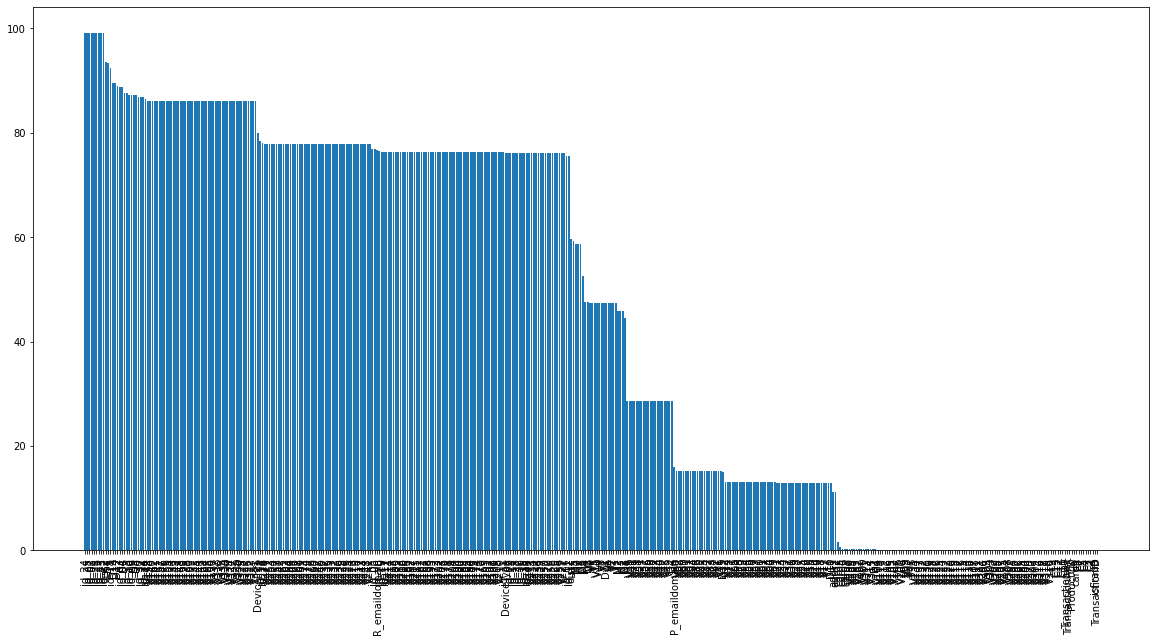

In [76]:
# Plot percentaje of nan values per column
plt.figure(figsize=(20, 10))
plt.bar(counts_nan.index, counts_nan['perct_nan_values'])
plt.xticks(rotation=90)
plt.show() 

Se puede ver que existen muchas columnas con muchos valores nulos, esto se puede deber a que cuando se hace el merge 'left', hay muchos id que aparecen en una base de datos pero en la otra no, tenemos que lidiar con estos valores nulos para poder utilizar modelos de machine learning.

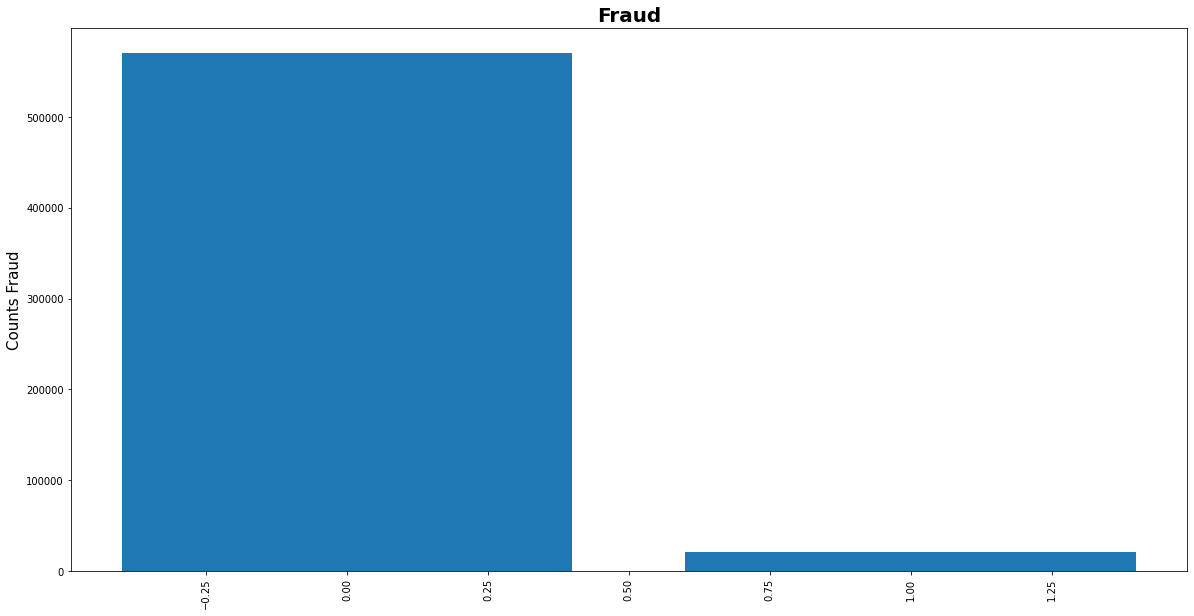

In [80]:
plt.figure(figsize=(20, 10))
plt.bar(df_full['isFraud'].value_counts().index, df_full['isFraud'].value_counts())
plt.xticks(rotation=90)
plt.title('Fraud', fontsize=20, fontweight='bold')
plt.ylabel('Counts Fraud', fontsize=15)
plt.show()


Se puede ver que es una base de datos desbalanceada porque hay mucho mas datos de la clase 0 que de la clase 1, esto puede afectar los resultados del modelo a nivel de precision al detectar cada clase. 

In [39]:
eda_num_cols = ['TransactionDT', 'TransactionAmt', 'card1']
eda_cat_cols = ['ProductCD', 'card4', 'card6']

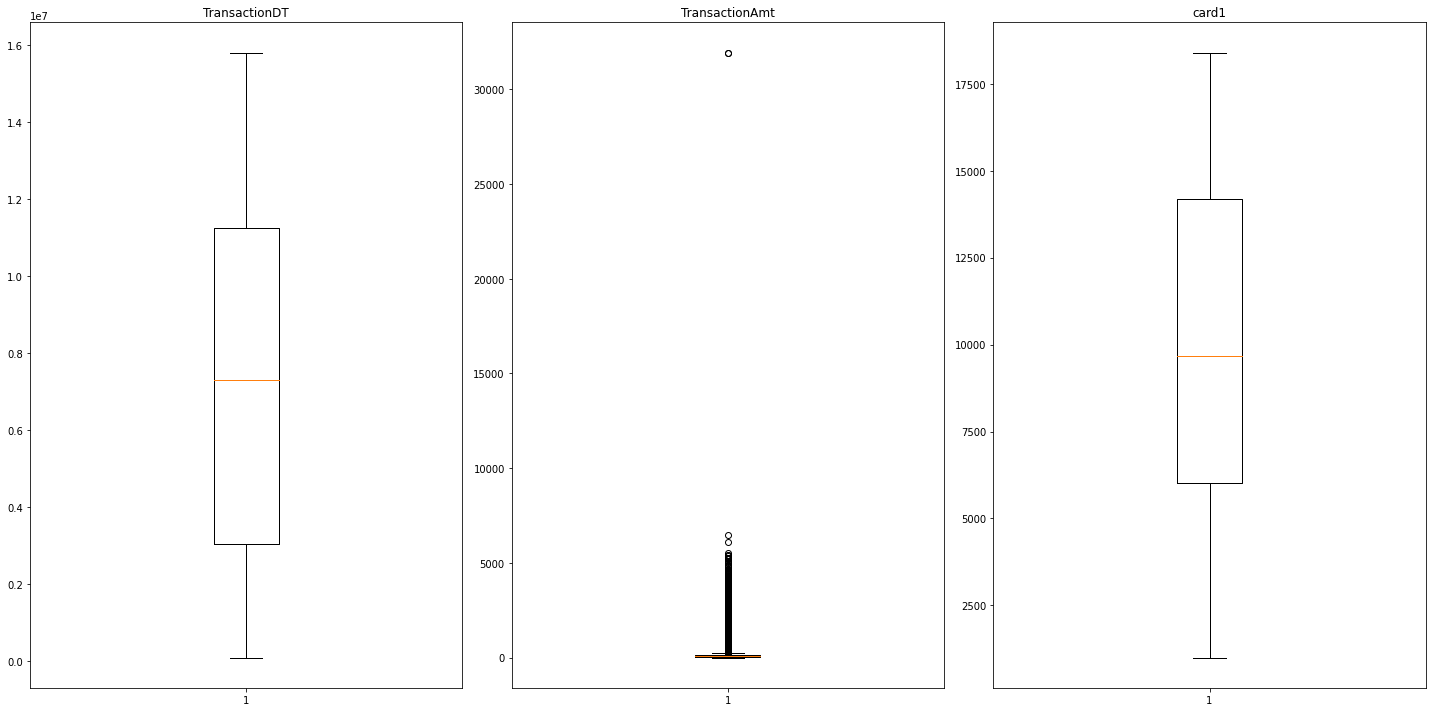

In [105]:
fig, axes = plt.subplots(1, len(eda_num_cols), figsize=(20, 10))
for i, col in enumerate(eda_num_cols):
    axes[i].boxplot(df_full[col])
    axes[i].set_title(col)
plt.tight_layout()
plt.show()

En las variables TransactionDT, y Card 1, no se evidencian datos atipicos en el boxplot, por otro lado para la variable Transaction Amt se ven muchos valores atipicos e incluso uno muy alejado de la escala de los datos.

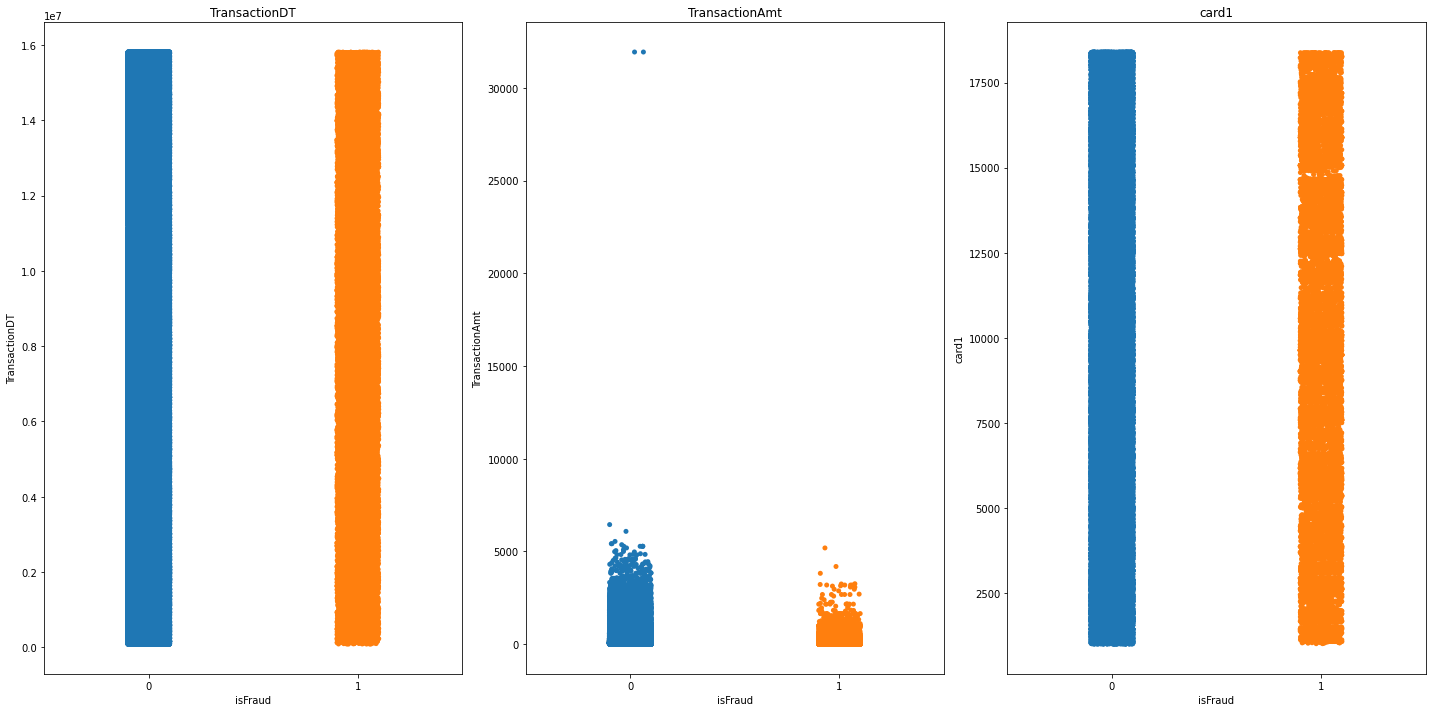

In [13]:
fig, axes = plt.subplots(1, len(eda_num_cols), figsize=(20, 10))
for i, col in enumerate(eda_num_cols):
    sns.stripplot(x="isFraud", y=col, data=df_full, jitter=True, edgecolor="gray", ax=axes[i])
    axes[i].set_title(col)
plt.tight_layout()
plt.show()

La distribucion de estas variables para cada clase tiene comportamientos similares, y los valores atipicos que veiamos en el boxplot para la variable TransactionAmt se pueden ver aca que hacen parte de la clase 0.

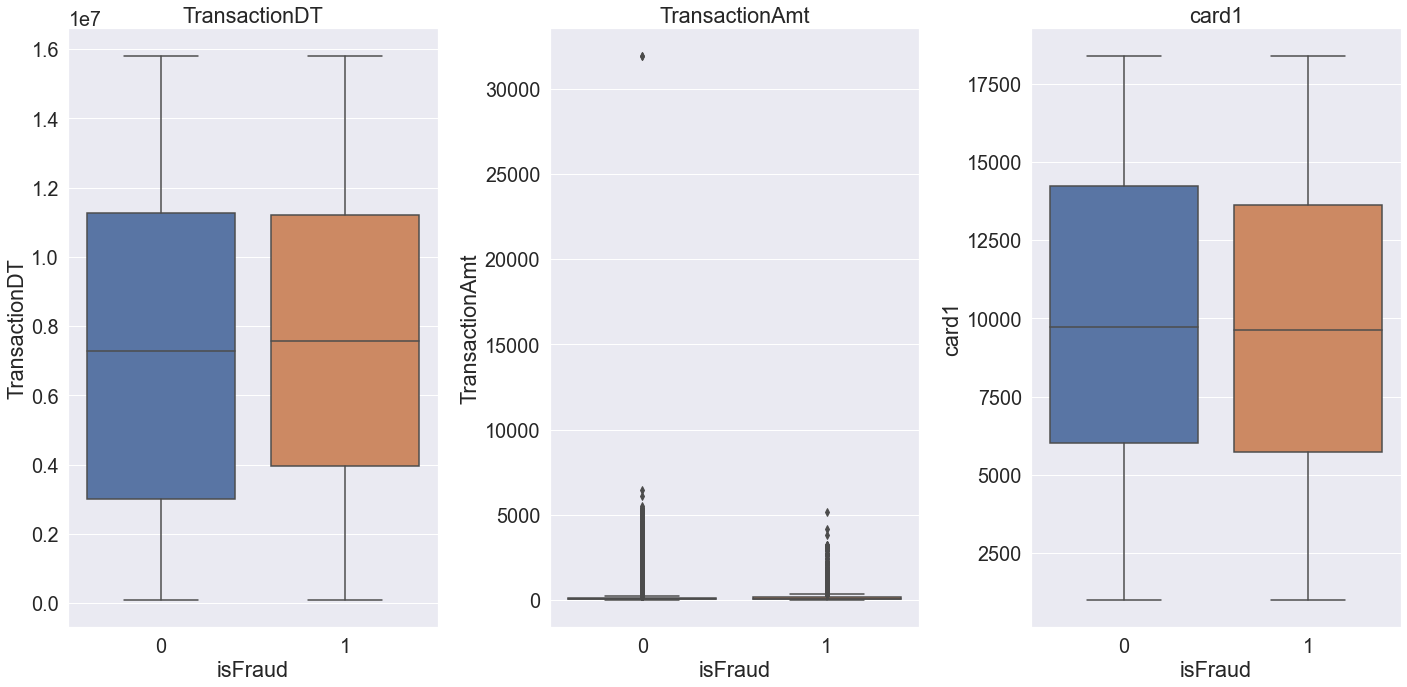

In [27]:
fig, axes = plt.subplots(1, len(eda_num_cols), figsize=(20, 10))
for i, col in enumerate(eda_num_cols):
    sns.boxplot(x="isFraud", y = col, data=df_full, ax=axes[i])
    axes[i].set_title(col)
plt.tight_layout()
plt.show()

Con este boxplot podemos ver la dispersion de estas variables con respecto a la variable respuesta. En TransactionAmt se ven valores atipicos en las dos clases y en las otras variables no se evidencian valores atipicos. En la variable TransactionDT se ve por las clases diferencia ligera en la mediana y en la variable card1 no se logra ver una diferencia.

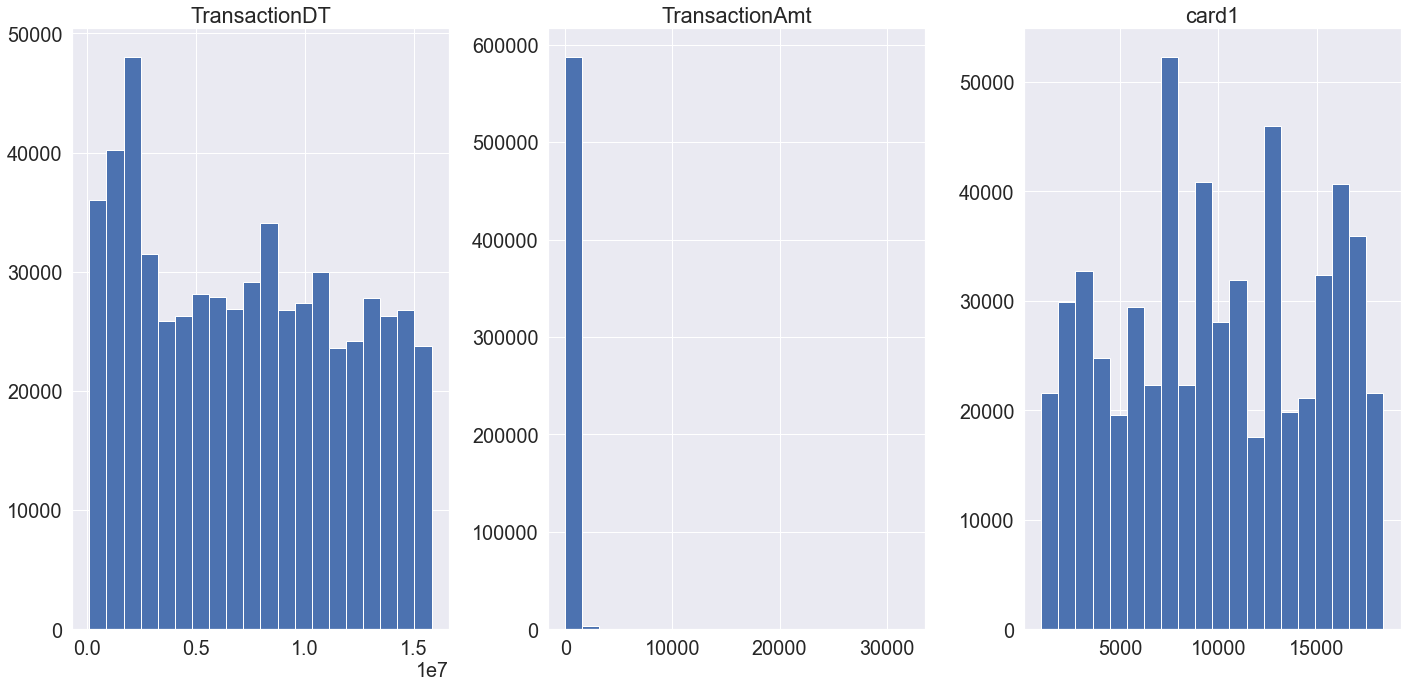

In [31]:
fig, axes = plt.subplots(1, len(eda_num_cols), figsize=(20, 10))
for i, col in enumerate(eda_num_cols):
    axes[i].hist(df_full[col], bins=20)
    axes[i].set_title(col)
plt.tight_layout()
plt.show()

En este histograma de las variables se puede ver que las variables TransactionDT y card1 son uniformes, y la variable TransactionAmt tiene un sesgo a la derecha.

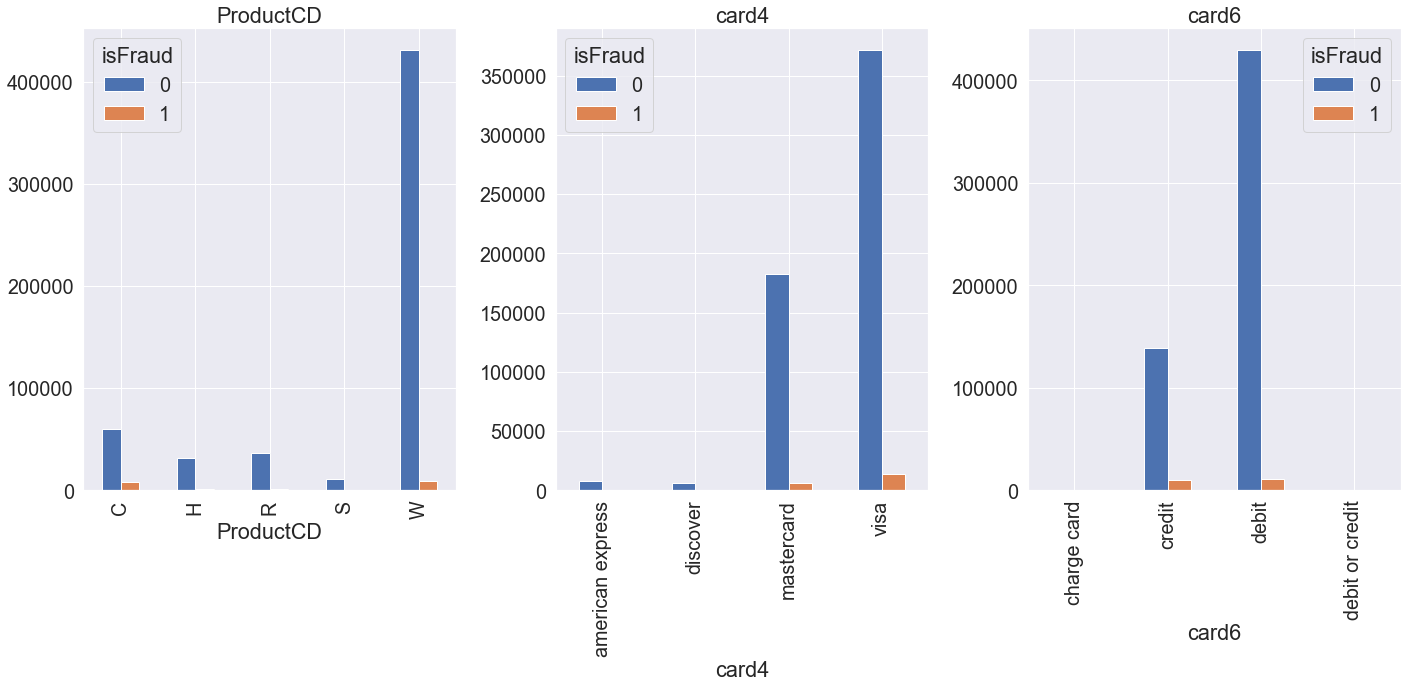

In [42]:
fig, axes = plt.subplots(1, len(eda_cat_cols), figsize=(20, 10))
for i, col in enumerate(eda_cat_cols):
    crosstab_result = pd.crosstab(df_full[col], df_full['isFraud'])
    ax = axes[i]
    crosstab_result.plot.bar(ax=ax)
    axes[i].set_title(col)
plt.tight_layout()
plt.show()

En estos diagramas de barras de estas variables categoricas, se puede ver cuales son las categorias mas frecuentes por clase. Muchas tarjetas visa, debito y product W.

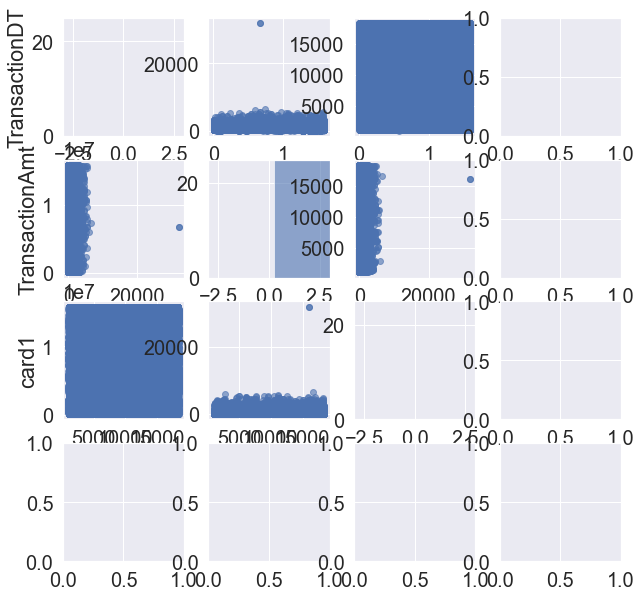

In [52]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for i in range(len(eda_num_cols)):
    for j in range(len(eda_num_cols)):
        if i == j:
            # Si es la misma variable en ambas dimensiones, crea un histograma en su lugar
            axes[i, j].hist(df_full[eda_num_cols[i]], bins=15, color='b', alpha=0.6)
            axes[i, j].set_xlim(-3, 3)
            axes[i, j].set_ylim(0, 25)
        else:
            # Si son variables diferentes, crea un gráfico de dispersión
            axes[i, j].scatter(df_full[eda_num_cols[i]], df_full[eda_num_cols[j]], alpha=0.6)

        if i == 3:
            axes[i, j].set_xlabel(eda_num_cols[j])
        if j == 0:
            axes[i, j].set_ylabel(eda_num_cols[i])

In [66]:
df_full.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.000000,588975.000000,586281.000000,524834.000000,524834.000000,...,139369.000000,45113.000000,139318.000000,139261.000000,5159.000000,5169.000000,4747.000000,5132.000000,5163.000000,77586.000000
mean,3.282270e+06,0.034990,7.372311e+06,135.027176,9898.734658,362.555488,153.194925,199.278897,290.733794,86.800630,...,189.451377,14.237337,353.128174,403.882666,368.269820,16.002708,12.800927,329.608924,149.070308,26.508597
std,1.704744e+05,0.183755,4.617224e+06,239.162522,4901.170153,157.793246,11.336444,41.244453,101.741072,2.690623,...,30.375360,1.561302,141.095343,152.160327,198.847038,6.897665,2.372447,97.461089,32.101995,3.737502
min,2.987000e+06,0.000000,8.640000e+04,0.251000,1000.000000,100.000000,100.000000,100.000000,100.000000,10.000000,...,100.000000,10.000000,100.000000,100.000000,100.000000,10.000000,11.000000,100.000000,100.000000,0.000000
25%,3.134635e+06,0.000000,3.027058e+06,43.321000,6019.000000,214.000000,150.000000,166.000000,204.000000,87.000000,...,166.000000,13.000000,266.000000,256.000000,252.000000,14.000000,11.000000,321.000000,119.000000,24.000000
50%,3.282270e+06,0.000000,7.306528e+06,68.769000,9678.000000,361.000000,150.000000,226.000000,299.000000,87.000000,...,166.000000,15.000000,341.000000,472.000000,252.000000,14.000000,11.000000,321.000000,149.000000,24.000000
75%,3.429904e+06,0.000000,1.124662e+07,125.000000,14184.000000,512.000000,150.000000,226.000000,330.000000,87.000000,...,225.000000,15.000000,427.000000,533.000000,486.500000,14.000000,15.000000,371.000000,169.000000,32.000000
max,3.577539e+06,1.000000,1.581113e+07,31937.391000,18396.000000,600.000000,231.000000,237.000000,540.000000,102.000000,...,229.000000,29.000000,671.000000,661.000000,854.000000,44.000000,26.000000,548.000000,216.000000,32.000000


Aca podemos ver como se relacionan las variables y sacar indicadores numericos de las variables.

In [6]:
missing_perc = (df_full.isnull().sum() / len(df_full)) * 100
cols_drop = missing_perc[missing_perc > 90].index
cols_drop

Index(['dist2', 'D7', 'id_07', 'id_08', 'id_18', 'id_21', 'id_22', 'id_23',
       'id_24', 'id_25', 'id_26', 'id_27'],
      dtype='object')

In [7]:
df_full.drop(columns=cols_drop, inplace=True)
df_full.shape

(590540, 422)

Empezaamos con el manejo de los datos nulos, eliminando las variables que tienen mas del 90% de sus datos nulos.

In [8]:
object_cols = list(df_full.select_dtypes(include=['object']).columns)
object_cols

['ProductCD',
 'card4',
 'card6',
 'P_emaildomain',
 'R_emaildomain',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'id_12',
 'id_15',
 'id_16',
 'id_28',
 'id_29',
 'id_30',
 'id_31',
 'id_33',
 'id_34',
 'id_35',
 'id_36',
 'id_37',
 'id_38',
 'DeviceType',
 'DeviceInfo']

In [8]:
imputer_cat = SimpleImputer(strategy='most_frequent')
df_full_cat = df_full.select_dtypes(include=['object'])
df_full_cat = imputer_cat.fit_transform(df_full_cat)
df_full_cat = pd.DataFrame(df_full_cat, columns=df_full.select_dtypes(include=['object']).columns)

# One Hot Encoding

ohe = OneHotEncoder(sparse=False, categories='auto', drop='first')
df_full_cat =  ohe.fit_transform(df_full_cat)
object_cols = list(df_full.select_dtypes(include=['object']).columns)
df_full_cat = pd.DataFrame(df_full_cat, columns=ohe.get_feature_names_out(object_cols))

df_full_cat['TransactionID'] = df_full['TransactionID']
df_full_cat

c:\Users\coold\miniconda3\envs\ml_venv\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,card4_discover,card4_mastercard,card4_visa,card6_credit,card6_debit,card6_debit or credit,...,DeviceInfo_verykoolS5524,DeviceInfo_verykoolS5525,DeviceInfo_verykoolS5530 Build/LMY47I,DeviceInfo_verykools4009,DeviceInfo_verykools5004,DeviceInfo_verykools5034,DeviceInfo_verykools5035,DeviceInfo_vivo,DeviceInfo_xs-Z47b7VqTMxs,TransactionID
0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2987000
1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2987001
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2987002
3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2987003
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2987004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3577535
590536,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3577536
590537,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3577537
590538,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3577538


Para las variables categorias imputamos los valores faltantes usando la estrategia 'most_frequent' y se aplica OneHotEncoding para transformar las variables

In [10]:
imputer_num = SimpleImputer(strategy='median')
df_full_num = df_full.select_dtypes(include=['float64', 'int64'])
df_full_num = df_full_num.drop(columns=['TransactionID', 'isFraud'], axis=1)
df_full_num = imputer_num.fit_transform(df_full_num)
df_full_num = pd.DataFrame(df_full_num, columns=df_full.select_dtypes(include=['float64', 'int64']).columns)

# Apply VIF
df_full_num = apply_vif(df_full_num.copy(), df_full_num.columns, verbose=True)
df_full_num

TransactionAmt, Columnas a eliminar: ['V246', 'V37', 'V61']
card1, Columnas a eliminar: ['V204']
card2, Columnas a eliminar: ['V63', 'V192', 'V124', 'V227']
card3, Columnas a eliminar: ['V50', 'V236', 'V88', 'V21', 'V261']
card5, Columnas a eliminar: ['V168', 'V24', 'V247', 'V120', 'V95', 'V138', 'V22', 'V321']
addr1, Columnas a eliminar: ['V225', 'V25', 'V171', 'V325', 'V257', 'V219', 'V289']
addr2, Columnas a eliminar: ['V93']
dist1, Columnas a eliminar: ['C11', 'V186', 'V280', 'V146', 'V34', 'V31']
C1, Columnas a eliminar: ['V166', 'V304', 'V235']
C2, Columnas a eliminar: ['V13', 'V194', 'V87', 'V296', 'V112', 'C1', 'V77']
C4, Columnas a eliminar: ['V51']
C5, Columnas a eliminar: ['V86', 'V117', 'V141']
C6, Columnas a eliminar: ['V67', 'V57', 'V14']
C7, Columnas a eliminar: ['V329']
C8, Columnas a eliminar: ['V39', 'V71', 'V156', 'V180']
C10, Columnas a eliminar: ['V83', 'V30', 'V199', 'V115', 'V175', 'V122', 'V103']
C12, Columnas a eliminar: ['V110', 'V49']
C13, Columnas a eliminar

,TransactionID,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,dist1,C2,...,V339,id_01,id_02,id_11,id_13,id_14,id_17,id_19,id_20,id_32
0,2987000.0,86400.0,68.50,13926.0,361.0,150.0,142.0,315.0,19.0,1.0,...,0.0,-5.0,125800.5,100.0,52.0,-300.0,166.0,341.0,472.0,24.0
1,2987001.0,86401.0,29.00,2755.0,404.0,150.0,102.0,325.0,8.0,1.0,...,0.0,-5.0,125800.5,100.0,52.0,-300.0,166.0,341.0,472.0,24.0
2,2987002.0,86469.0,59.00,4663.0,490.0,150.0,166.0,330.0,287.0,1.0,...,0.0,-5.0,125800.5,100.0,52.0,-300.0,166.0,341.0,472.0,24.0
3,2987003.0,86499.0,50.00,18132.0,567.0,150.0,117.0,476.0,8.0,5.0,...,0.0,-5.0,125800.5,100.0,52.0,-300.0,166.0,341.0,472.0,24.0
4,2987004.0,86506.0,50.00,4497.0,514.0,150.0,102.0,420.0,8.0,1.0,...,0.0,0.0,70787.0,100.0,52.0,-480.0,166.0,542.0,144.0,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535.0,15811047.0,49.00,6550.0,361.0,150.0,226.0,272.0,48.0,1.0,...,0.0,-5.0,125800.5,100.0,52.0,-300.0,166.0,341.0,472.0,24.0
590536,3577536.0,15811049.0,39.50,10444.0,225.0,150.0,224.0,204.0,8.0,1.0,...,0.0,-5.0,125800.5,100.0,52.0,-300.0,166.0,341.0,472.0,24.0
590537,3577537.0,15811079.0,30.95,12037.0,595.0,150.0,224.0,231.0,8.0,1.0,...,0.0,-5.0,125800.5,100.0,52.0,-300.0,166.0,341.0,472.0,24.0
590538,3577538.0,15811088.0,117.00,7826.0,481.0,150.0,224.0,387.0,3.0,1.0,...,0.0,-5.0,125800.5,100.0,52.0,-300.0,166.0,341.0,472.0,24.0


Eliminamos las variables altamente correlaciondas que tengan VIF > 5

In [9]:
df_full_num = pd.read_csv('df_full_num.csv')
df_full_num['isFraud'] = df_full['isFraud']

In [10]:
df_full = pd.merge(df_full_num, df_full_cat, on='TransactionID', how='left')
df_full.shape

(590540, 2515)

In [11]:
class1 = df_full.query("isFraud == 1")
class1 = class1.sample(int(len(class1)*0.03)).reset_index(drop=True)
class0 = df_full.query("isFraud == 0")
class0 = class0.sample(int(len(class0)*0.03)).reset_index(drop=True)

indices_class1 = np.random.permutation(class1.index)
indices_class0 = np.random.permutation(class0.index)

class1 = class1.iloc[indices_class1]
class0 = class0.iloc[indices_class0]

df_sample = pd.concat([class1, class0], ignore_index=True)
df_sample.reset_index(drop=True, inplace=True)
df_sample

,TransactionID,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,dist1,C2,...,DeviceInfo_verykoolS5019,DeviceInfo_verykoolS5524,DeviceInfo_verykoolS5525,DeviceInfo_verykoolS5530 Build/LMY47I,DeviceInfo_verykools4009,DeviceInfo_verykools5004,DeviceInfo_verykools5034,DeviceInfo_verykools5035,DeviceInfo_vivo,DeviceInfo_xs-Z47b7VqTMxs
0,3319303.0,8185867.0,100.000,9350.0,111.0,150.0,162.0,310.0,8.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3388411.0,10114406.0,47.973,9917.0,142.0,185.0,138.0,299.0,8.0,47.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2989598.0,147621.0,100.000,2616.0,327.0,150.0,223.0,123.0,8.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3357624.0,9225325.0,33.957,15146.0,311.0,185.0,102.0,299.0,8.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3380486.0,9879546.0,49.786,9633.0,130.0,185.0,138.0,299.0,8.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17710,3183455.0,4413541.0,14.808,9366.0,555.0,119.0,137.0,299.0,8.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17711,3074100.0,1827776.0,150.000,16679.0,463.0,144.0,147.0,426.0,8.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17712,3225851.0,5627345.0,117.000,7919.0,194.0,150.0,202.0,220.0,8.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17713,3193950.0,4753189.0,57.950,15847.0,216.0,150.0,226.0,225.0,8.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Debido a que la cantidad de los datos originales es muy grande, se decide hacer un sample del 3% de los datos para disminuir la dimensionalidad y poder correr todos los modelos con la capacidad de computo disponible.

In [12]:
X = df_sample.drop(columns=['isFraud'])
y = df_sample['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [13]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12400, 2514), (5315, 2514), (12400,), (5315,))

In [14]:
scorer = make_scorer(roc_auc_score)

Empezamos a aplicar los modelos de machine learning, usando PipeLine y GridSearchCV con StratifiedKFold para este problema de classificacion desbalanceado y que siempre se tenga en cuenta las dos clases en los modelos. Los modelos se entrenan usando el scorer de AUC y una vez es escogido el mejor modelo se guarda con pickle para no tener que hacer el tunning de los hyperparametros todo el tiempo.

# KNN

In [45]:
grid_knn = None
if (len(glob.glob("knn_model_class.pkl")) != 0):
    
     grid_knn = pickle.load(open('knn_model_class.pkl','rb'))
     
else:
    
    pipe = Pipeline([
    ('scaler', MinMaxScaler()), 
    ('knn', KNeighborsClassifier())])
    
    param_grid = {
    'knn__n_neighbors': list(range(1, 5)),
    'knn__weights': ['uniform', 'distance'],
    'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'knn__p': [1, 2]
    }

    grid_knn = GridSearchCV(pipe, param_grid, cv=StratifiedKFold(n_splits=5), scoring=scorer, n_jobs=-1)
    grid_knn.fit(X_train, y_train)
    
    # Export model to pickle
    pickle.dump(grid_knn, open('knn_model_class.pkl', 'wb'))
    
print("Best parameters: ", grid_knn.best_params_)
print("Best score: ", grid_knn.best_score_)

Best parameters:  {'knn__algorithm': 'ball_tree', 'knn__n_neighbors': 1, 'knn__p': 1, 'knn__weights': 'uniform'}
Best score:  0.5888677597830869


In [46]:
# Create a dictionary with precisssion, recall, f1-score and AUC
y_pred_knn = grid_knn.predict(X_test)
report = classification_report(y_test, y_pred_knn, output_dict=True)
results_metrics = [{"Model":'KNN', "precision":precision_score(y_test, y_pred_knn), "recall":recall_score(y_test, y_pred_knn),
                    "f1-score":f1_score(y_test, y_pred_knn), "auc":roc_auc_score(y_test, y_pred_knn)}]
print(report)
print(results_metrics)


{'0': {'precision': 0.9719806763285024, 'recall': 0.9806979918112693, 'f1-score': 0.9763198757763975, 'support': 5129.0}, '1': {'precision': 0.29285714285714287, 'recall': 0.22043010752688172, 'f1-score': 0.25153374233128833, 'support': 186.0}, 'accuracy': 0.9540921919096895, 'macro avg': {'precision': 0.6324189095928227, 'recall': 0.6005640496690755, 'f1-score': 0.6139268090538429, 'support': 5315.0}, 'weighted avg': {'precision': 0.9482145470292225, 'recall': 0.9540921919096895, 'f1-score': 0.9509557702597858, 'support': 5315.0}}
[{'Model': 'KNN', 'precision': 0.29285714285714287, 'recall': 0.22043010752688172, 'f1-score': 0.25153374233128833, 'auc': 0.6005640496690755}]


# RIDGE

In [47]:
grid_ridge = None

if (len(glob.glob("ridge_model_class.pkl")) != 0):
    
    grid_ridge = pickle.load(open('ridge_model_class.pkl','rb'))
        
else:
    
    pipe = Pipeline([
    ('scaler', MinMaxScaler()), 
    ('ridge', RidgeClassifier())])
    
    param_grid = {
    'ridge__alpha': [0.01, 0.1, 1, 10, 100],
    'ridge__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag']
    }

    grid_ridge = GridSearchCV(pipe, param_grid, cv=StratifiedKFold(n_splits=5), scoring=scorer, n_jobs=-1)
    grid_ridge.fit(X_train, y_train)
    
    # Export model to pickle
    pickle.dump(grid_ridge, open('ridge_model_class.pkl', 'wb'))
    
print("Best parameters: ", grid_ridge.best_params_)
print("Best score: ", grid_ridge.best_score_)

Best parameters:  {'ridge__alpha': 0.01, 'ridge__solver': 'auto'}
Best score:  0.5509264797553717


In [48]:
# Create a dictionary with precisssion, recall, f1-score and AUC
y_pred_ridge = grid_ridge.predict(X_test)
report = classification_report(y_test, y_pred_ridge, output_dict=True)
results_metrics.append({"Model":'Ridge', "precision":precision_score(y_test, y_pred_ridge), "recall":recall_score(y_test, y_pred_ridge),
                    "f1-score":f1_score(y_test, y_pred_ridge), "auc":roc_auc_score(y_test, y_pred_ridge)})
print(report)
print(results_metrics)

{'0': {'precision': 0.9683951551854656, 'recall': 0.9976603626437902, 'f1-score': 0.9828099491020839, 'support': 5129.0}, '1': {'precision': 0.6129032258064516, 'recall': 0.10215053763440861, 'f1-score': 0.1751152073732719, 'support': 186.0}, 'accuracy': 0.9663217309501411, 'macro avg': {'precision': 0.7906491904959586, 'recall': 0.5499054501390994, 'f1-score': 0.5789625782376779, 'support': 5315.0}, 'weighted avg': {'precision': 0.955954609773519, 'recall': 0.9663217309501411, 'f1-score': 0.9545444322701818, 'support': 5315.0}}
[{'Model': 'KNN', 'precision': 0.29285714285714287, 'recall': 0.22043010752688172, 'f1-score': 0.25153374233128833, 'auc': 0.6005640496690755}, {'Model': 'Ridge', 'precision': 0.6129032258064516, 'recall': 0.10215053763440861, 'f1-score': 0.1751152073732719, 'auc': 0.5499054501390994}]


# LASSO

In [49]:
# Apply the same grid search using Lasso Classifier
grid_lasso = None

if (len(glob.glob("lasso_model_class.pkl")) != 0):
    
    grid_lasso = pickle.load(open('lasso_model_class.pkl','rb'))
    
else:
    
    pipe = Pipeline([
    ('scaler', MinMaxScaler()), 
    ('lasso', LogisticRegression())])
    
    param_grid = {
        'lasso__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'lasso__penalty': ['l1'],
        'lasso__solver': ['liblinear']}

    grid_lasso = GridSearchCV(pipe, param_grid, cv=StratifiedKFold(n_splits=5), scoring=scorer, n_jobs=-1)
    grid_lasso.fit(X_train, y_train)
    
    # Export model to pickle
    pickle.dump(grid_lasso, open('lasso_model_class.pkl', 'wb'))
    
print("Best parameters: ", grid_lasso.best_params_)
print("Best score: ", grid_lasso.best_score_)

Best parameters:  {'lasso__C': 100, 'lasso__penalty': 'l1', 'lasso__solver': 'liblinear'}
Best score:  0.5894081735050201


In [50]:
# Create a dictionary with precisssion, recall, f1-score and AUC
y_pred_lasso = grid_lasso.predict(X_test)
report = classification_report(y_test, y_pred_lasso, output_dict=True)
results_metrics.append({"Model":'Lasso', "precision":precision_score(y_test, y_pred_lasso), "recall":recall_score(y_test, y_pred_lasso),
                    "f1-score":f1_score(y_test, y_pred_lasso), "auc":roc_auc_score(y_test, y_pred_lasso)})
print(report)
print(results_metrics)

{'0': {'precision': 0.9726838586437441, 'recall': 0.9927861181516865, 'f1-score': 0.9826321883442687, 'support': 5129.0}, '1': {'precision': 0.5375, 'recall': 0.23118279569892472, 'f1-score': 0.3233082706766917, 'support': 186.0}, 'accuracy': 0.9661335841956726, 'macro avg': {'precision': 0.7550919293218721, 'recall': 0.6119844569253056, 'f1-score': 0.6529702295104802, 'support': 5315.0}, 'weighted avg': {'precision': 0.9574544705519782, 'recall': 0.9661335841956726, 'f1-score': 0.9595589524672848, 'support': 5315.0}}
[{'Model': 'KNN', 'precision': 0.29285714285714287, 'recall': 0.22043010752688172, 'f1-score': 0.25153374233128833, 'auc': 0.6005640496690755}, {'Model': 'Ridge', 'precision': 0.6129032258064516, 'recall': 0.10215053763440861, 'f1-score': 0.1751152073732719, 'auc': 0.5499054501390994}, {'Model': 'Lasso', 'precision': 0.5375, 'recall': 0.23118279569892472, 'f1-score': 0.3233082706766917, 'auc': 0.6119844569253057}]


# NAIVE BAYES

In [52]:
# Apply the same grid search using Naive Bayes Classifier
grid_nb = None

if (len(glob.glob("nb_model_class.pkl")) != 0):
    
    grid_nb = pickle.load(open('nb_model_class.pkl','rb'))
    
else:
    
    pipe = Pipeline([ 
    ('nb', GaussianNB())])
    
    param_grid = {
    'nb__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
    }

    grid_nb = GridSearchCV(pipe, param_grid, cv=StratifiedKFold(n_splits=5), scoring=scorer, n_jobs=-1)
    grid_nb.fit(X_train, y_train)
    
    # Export model to pickle
    pickle.dump(grid_nb, open('nb_model_class.pkl', 'wb'))
    
print("Best parameters: ", grid_nb.best_params_)
print("Best score: ", grid_nb.best_score_)

Best parameters:  {'nb__var_smoothing': 1e-05}
Best score:  0.5351489817297628


In [53]:
# Create a dictionary with precisssion, recall, f1-score and AUC
y_pred_nb = grid_nb.predict(X_test)
report = classification_report(y_test, y_pred_nb, output_dict=True)
results_metrics.append({"Model":'Naive Bayes', "precision":precision_score(y_test, y_pred_nb), "recall":recall_score(y_test, y_pred_nb),
                    "f1-score":f1_score(y_test, y_pred_nb), "auc":roc_auc_score(y_test, y_pred_nb)})
print(report)
print(results_metrics)

{'0': {'precision': 0.9669663799843627, 'recall': 0.9645155000974849, 'f1-score': 0.9657393850658857, 'support': 5129.0}, '1': {'precision': 0.08542713567839195, 'recall': 0.0913978494623656, 'f1-score': 0.0883116883116883, 'support': 186.0}, 'accuracy': 0.9339604891815616, 'macro avg': {'precision': 0.5261967578313773, 'recall': 0.5279566747799253, 'f1-score': 0.527025536688787, 'support': 5315.0}, 'weighted avg': {'precision': 0.9361166529023475, 'recall': 0.9339604891815616, 'f1-score': 0.9350335428088244, 'support': 5315.0}}
[{'Model': 'KNN', 'precision': 0.29285714285714287, 'recall': 0.22043010752688172, 'f1-score': 0.25153374233128833, 'auc': 0.6005640496690755}, {'Model': 'Ridge', 'precision': 0.6129032258064516, 'recall': 0.10215053763440861, 'f1-score': 0.1751152073732719, 'auc': 0.5499054501390994}, {'Model': 'Lasso', 'precision': 0.5375, 'recall': 0.23118279569892472, 'f1-score': 0.3233082706766917, 'auc': 0.6119844569253057}, {'Model': 'Naive Bayes', 'precision': 0.0854271

# XGBOOST

In [54]:
# Apply the same grid search using XGBoost Classifier
grid_xgb = None

if (len(glob.glob("xgb_model_class.pkl")) != 0):
    
    grid_xgb = pickle.load(open('xgb_model_class.pkl','rb'))
    
else:
    
    pipe = Pipeline([ 
    ('xgb', GradientBoostingClassifier())])
    
    param_grid = {
    'xgb__max_depth': [3, 4, 5],
    'xgb__learning_rate': [0.01, 0.1],
    'xgb__n_estimators': [100, 200]
    }

    grid_xgb = GridSearchCV(pipe, param_grid, cv=StratifiedKFold(n_splits=5), scoring=scorer, n_jobs=-1)
    grid_xgb.fit(X_train, y_train)
    
    # Export model to pickle
    pickle.dump(grid_xgb, open('xgb_model_class.pkl', 'wb'))
    
print("Best parameters: ", grid_xgb.best_params_)
print("Best score: ", grid_xgb.best_score_)

Best parameters:  {'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__n_estimators': 200}
Best score:  0.6453275471402342


In [55]:
# Create a dictionary with precisssion, recall, f1-score and AUC
y_pred_xgb = grid_xgb.predict(X_test)
report = classification_report(y_test, y_pred_xgb, output_dict=True)
results_metrics.append({"Model":'XGBoost', "precision":precision_score(y_test, y_pred_xgb), "recall":recall_score(y_test, y_pred_xgb),
                    "f1-score":f1_score(y_test, y_pred_xgb), "auc":roc_auc_score(y_test, y_pred_xgb)})
print(report)
print(results_metrics)

{'0': {'precision': 0.9736389684813753, 'recall': 0.9937609670501072, 'f1-score': 0.9835970667695871, 'support': 5129.0}, '1': {'precision': 0.6, 'recall': 0.25806451612903225, 'f1-score': 0.3609022556390977, 'support': 186.0}, 'accuracy': 0.9680150517403575, 'macro avg': {'precision': 0.7868194842406877, 'recall': 0.6259127415895698, 'f1-score': 0.6722496612043425, 'support': 5315.0}, 'weighted avg': {'precision': 0.9605633620585088, 'recall': 0.9680150517403575, 'f1-score': 0.9618056773302135, 'support': 5315.0}}
[{'Model': 'KNN', 'precision': 0.29285714285714287, 'recall': 0.22043010752688172, 'f1-score': 0.25153374233128833, 'auc': 0.6005640496690755}, {'Model': 'Ridge', 'precision': 0.6129032258064516, 'recall': 0.10215053763440861, 'f1-score': 0.1751152073732719, 'auc': 0.5499054501390994}, {'Model': 'Lasso', 'precision': 0.5375, 'recall': 0.23118279569892472, 'f1-score': 0.3233082706766917, 'auc': 0.6119844569253057}, {'Model': 'Naive Bayes', 'precision': 0.08542713567839195, 'r

# SVM

In [56]:
# Apply the same grid search using SVM Classifier
grid_svm = None

if (len(glob.glob("svm_model_class.pkl")) != 0):
    
    grid_svm = pickle.load(open('svm_model_class.pkl','rb'))
    
else:
    
    pipe = Pipeline([
    ('scaler', MinMaxScaler()), 
    ('svm', SVC())])
    
    param_grid = {
    'svm__C': [0.1, 1],
    'svm__kernel': ['rbf', 'sigmoid', 'poly'],
    'svm__gamma': ['scale', 'auto', 0.1, 1]
    }

    grid_svm = GridSearchCV(pipe, param_grid, cv=StratifiedKFold(n_splits=5), scoring=scorer, n_jobs=-1)
    grid_svm.fit(X_train, y_train)
    
    # Export model to pickle
    pickle.dump(grid_svm, open('svm_model_class.pkl', 'wb'))
    
print("Best parameters: ", grid_svm.best_params_)
print("Best score: ", grid_svm.best_score_)

Best parameters:  {'svm__C': 0.1, 'svm__gamma': 1, 'svm__kernel': 'poly'}
Best score:  0.6150370076777703


In [57]:
# Create a dictionary with precisssion, recall, f1-score and AUC
y_pred_svm = grid_svm.predict(X_test)
report = classification_report(y_test, y_pred_svm, output_dict=True)
results_metrics.append({"Model":'SVM', "precision":precision_score(y_test, y_pred_svm), "recall":recall_score(y_test, y_pred_svm),
                    "f1-score":f1_score(y_test, y_pred_svm), "auc":roc_auc_score(y_test, y_pred_svm)})
print(report)
print(results_metrics)

{'0': {'precision': 0.9737914967967385, 'recall': 0.9779684148956912, 'f1-score': 0.9758754863813229, 'support': 5129.0}, '1': {'precision': 0.31097560975609756, 'recall': 0.27419354838709675, 'f1-score': 0.2914285714285714, 'support': 186.0}, 'accuracy': 0.9533396048918156, 'macro avg': {'precision': 0.642383553276418, 'recall': 0.6260809816413939, 'f1-score': 0.6336520289049472, 'support': 5315.0}, 'weighted avg': {'precision': 0.950596058416765, 'recall': 0.9533396048918156, 'f1-score': 0.951923063769618, 'support': 5315.0}}
[{'Model': 'KNN', 'precision': 0.29285714285714287, 'recall': 0.22043010752688172, 'f1-score': 0.25153374233128833, 'auc': 0.6005640496690755}, {'Model': 'Ridge', 'precision': 0.6129032258064516, 'recall': 0.10215053763440861, 'f1-score': 0.1751152073732719, 'auc': 0.5499054501390994}, {'Model': 'Lasso', 'precision': 0.5375, 'recall': 0.23118279569892472, 'f1-score': 0.3233082706766917, 'auc': 0.6119844569253057}, {'Model': 'Naive Bayes', 'precision': 0.08542713

# MLP

In [58]:
# Apply the same grid search using MLP Classifier
grid_mlp = None

if (len(glob.glob("mlp_model_class.pkl")) != 0):
    
    grid_mlp = pickle.load(open('mlp_model_class.pkl','rb'))
    
else:
    
    pipe = Pipeline([
    ('scaler', MinMaxScaler()), 
    ('mlp', MLPClassifier())])
    
    param_grid = {
    'mlp__hidden_layer_sizes': [(10,30,10),(20,)],
    'mlp__activation': ['tanh', 'relu'],
    'mlp__solver': ['sgd', 'adam'],
    'mlp__alpha': [0.0001, 0.05],
    }

    grid_mlp = GridSearchCV(pipe, param_grid, cv=StratifiedKFold(n_splits=5), scoring=scorer, n_jobs=-1)
    grid_mlp.fit(X_train, y_train)
    
    # Export model to pickle
    pickle.dump(grid_mlp, open('mlp_model_class.pkl', 'wb'))
    
print("Best parameters: ", grid_mlp.best_params_)
print("Best score: ", grid_mlp.best_score_)

Best parameters:  {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (10, 30, 10), 'mlp__solver': 'adam'}
Best score:  0.5993172450718208


In [59]:
# Create a dictionary with precisssion, recall, f1-score and AUC
y_pred_mlp = grid_mlp.predict(X_test)
report = classification_report(y_test, y_pred_mlp, output_dict=True)
results_metrics.append({"Model":'MLP', "precision":precision_score(y_test, y_pred_mlp), "recall":recall_score(y_test, y_pred_mlp),
                    "f1-score":f1_score(y_test, y_pred_mlp), "auc":roc_auc_score(y_test, y_pred_mlp)})
print(report)
print(results_metrics)

{'0': {'precision': 0.9719144058081773, 'recall': 0.9918112692532658, 'f1-score': 0.9817620380198785, 'support': 5129.0}, '1': {'precision': 0.48148148148148145, 'recall': 0.20967741935483872, 'f1-score': 0.29213483146067415, 'support': 186.0}, 'accuracy': 0.9644402634054563, 'macro avg': {'precision': 0.7266979436448294, 'recall': 0.6007443443040522, 'f1-score': 0.6369484347402763, 'support': 5315.0}, 'weighted avg': {'precision': 0.9547515602908179, 'recall': 0.9644402634054563, 'f1-score': 0.9576283295683241, 'support': 5315.0}}
[{'Model': 'KNN', 'precision': 0.29285714285714287, 'recall': 0.22043010752688172, 'f1-score': 0.25153374233128833, 'auc': 0.6005640496690755}, {'Model': 'Ridge', 'precision': 0.6129032258064516, 'recall': 0.10215053763440861, 'f1-score': 0.1751152073732719, 'auc': 0.5499054501390994}, {'Model': 'Lasso', 'precision': 0.5375, 'recall': 0.23118279569892472, 'f1-score': 0.3233082706766917, 'auc': 0.6119844569253057}, {'Model': 'Naive Bayes', 'precision': 0.0854

In [60]:
pd.DataFrame(results_metrics)

,Model,precision,recall,f1-score,auc
0,KNN,0.292857,0.220430,0.251534,0.600564
1,Ridge,0.612903,0.102151,0.175115,0.549905
2,Lasso,0.537500,0.231183,0.323308,0.611984
3,Naive Bayes,0.085427,0.091398,0.088312,0.527957
4,XGBoost,0.600000,0.258065,0.360902,0.625913
5,SVM,0.310976,0.274194,0.291429,0.626081
6,MLP,0.481481,0.209677,0.292135,0.600744


De los resultados podemos concluir que el mejor modelo es XGBoost con un AUC de 62.25%, cercano a este esta SVM y LASSO. Todos los valores de AUC estan entre 0.5 y 0.6, estos son los mas altos porque el scoring del modelo se enfoco en esta metrica. Cuando revisamos las otras metricas vemos malos resultados para algunos modelos. El recall y el f1-score obtienen valores de 0.1 a 0.3, muy bajitos, lo cual se debe a que el dataset se encuentra desbalanceado. La metrica de precision tiene un rango de valores de 0.2 y 0.6, solo 3 modelos tienen valores superiores a 0.5, esta tambien se ve afectada por el desbalanceo de las clases. Se podrian tener mejores resultados al aplicar tecnicas de balanceo de datos. Se puede concluir que el mejor modelo evidentemente logra ser XGBoost obteniendo el maximo AUC y los valores de las otras metricas alto respecto a los otros modelos. S